In [24]:
import pandas as pd
import numpy as np
#import graphviz
import xgboost as xgb
import time
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.cross_validation import train_test_split
from collections import Counter
from pandas_ml import ConfusionMatrix

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
#fixing random state
random_state=1

Note that I have imported 2 forms of XGBoost:

xgb – this is the direct xgboost library. I will use a specific function “cv” from this library
XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM

In [7]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = X_train["y"]

In [5]:
X_train.head()

,Unnamed: 0,id,age,n_null,dac_y,dac_m,dac_d,dac_wn,dac_w_0,dac_w_1,...,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,all_null,y
0,137021,d1mm9tcy42,62.0,0,2014,1,1,1,0,0,...,15.0,4.0,9.0,10.0,14.0,5.0,1.0,0.0,1,11
1,137022,yo8nz8bqcq,46.0,2,2014,1,1,1,0,0,...,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1,7
2,137023,4grx6yxeby,42.0,2,2014,1,1,1,0,0,...,1.0,1.0,0.0,1.0,6.0,2.0,0.0,0.0,1,7
3,137024,ncf87guaf0,52.0,2,2014,1,1,1,0,0,...,28.0,29.0,7.0,6.0,7.0,7.0,1.0,0.0,1,7
4,137025,4rvqpxoh3h,25.0,3,2014,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5


In [6]:
#  The targeted label # unbalanced
Counter(y_train)

Counter({0: 152,
         1: 440,
         2: 250,
         3: 707,
         4: 1435,
         5: 731,
         6: 979,
         7: 45041,
         8: 247,
         9: 83,
         10: 20095,
         11: 3655})

In [8]:
target = "y"
IDcol = "id"
Indexcol = "Unnamed: 0"
XV = X_train[[x for x in X_train.columns if x not in [target, IDcol,Indexcol]]]
yv = X_train["y"]
XV_train, XV_valid, yv_train, yv_valid = train_test_split(XV, yv,test_size=0.15, random_state=random_state)

In [8]:
start_time = time.time()
XV_train, XV_valid, yv_train, yv_valid = train_test_split(XV, yv,test_size=0.15, random_state=random_state)
#Gradient boosting
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=10000, objective='multi:softprob', seed = random_state)
xgb.fit(XV_train, yv_train, eval_set=[(XV_valid, yv_valid)], eval_metric='mlogloss', early_stopping_rounds=15, verbose=False)
xgb.n_estimators = xgb.best_iteration
print("--- %s seconds ---" % (time.time() - start_time))

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


--- 3056.82548213 seconds ---


In [9]:
xgb.get_params

<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=111,
       n_jobs=1, nthread=1, objective='multi:softprob', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1)>

In [15]:
print ("the best iteration is %s" %xgb.best_iteration)
print ("the best score is %s" %xgb.best_score)
print ("the best tree_limit is %s" % xgb.best_ntree_limit)

the best iteration is 111
the best score is 0.889277
the best tree_limit is 112


<function matplotlib.pyplot.show>

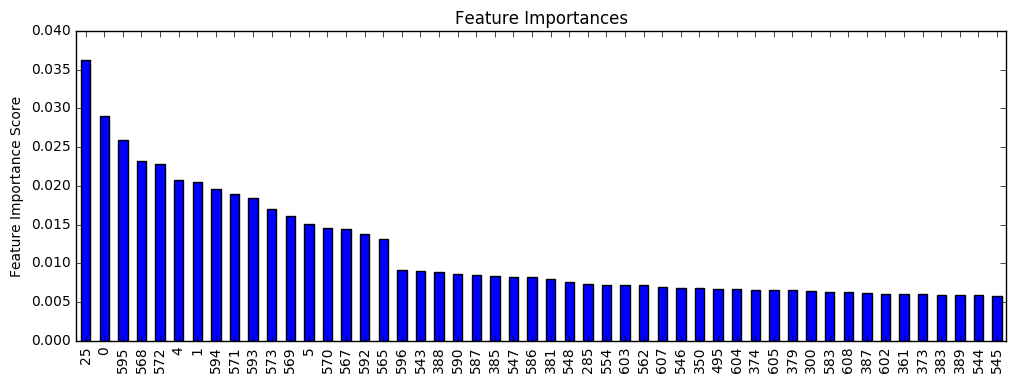

In [10]:
feat_imp = pd.Series(xgb.feature_importances_).sort_values(ascending=False)[:50]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show

In [56]:
# xgb.plot_tree(xgb.Booster)

### Tune max_depth

In [19]:
start_time = time.time()
param_test1 = {
 'max_depth':range(3,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 111, max_depth = 5,
 min_child_weight = 1, gamma = 0, objective= 'multi:softprob', scale_pos_weight = 1, random_state = random_state), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs = 4, iid = False, cv = 5)
gsearch1.fit(XV_train, yv_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
print("--- %s seconds ---" % (time.time() - start_time))

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs i

--- 15726.2919521 seconds ---


In [43]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_,gsearch1.best_estimator_

([mean: -0.92904, std: 0.00280, params: {'max_depth': 3},
  mean: -0.92424, std: 0.00454, params: {'max_depth': 5},
  mean: -0.92920, std: 0.00511, params: {'max_depth': 7},
  mean: -0.93906, std: 0.00507, params: {'max_depth': 9}],
 {'max_depth': 5},
 -0.9242406080080583,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=5, min_child_weight=1, missing=None, n_estimators=111,
        n_jobs=1, nthread=1, objective='multi:softprob', random_state=1,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
        subsample=1))

### Tuning min_child_weight

In [35]:
start_time = time.time()
param_test2 = {
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 111, max_depth = 5,
 min_child_weight = 1, gamma = 0, objective= 'multi:softprob', scale_pos_weight = 1, random_state = random_state), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs = 4, iid = False, cv = 5)
gsearch2.fit(XV_train, yv_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_
print("--- %s seconds ---" % (time.time() - start_time))

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs i

--- 11055.7630069 seconds ---


In [42]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_,gsearch2.best_estimator_

([mean: -0.92424, std: 0.00454, params: {'min_child_weight': 1},
  mean: -0.92426, std: 0.00417, params: {'min_child_weight': 3},
  mean: -0.92417, std: 0.00393, params: {'min_child_weight': 5}],
 {'min_child_weight': 5},
 -0.9241735957814893,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=5, min_child_weight=5, missing=None, n_estimators=111,
        n_jobs=1, nthread=1, objective='multi:softprob', random_state=1,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
        subsample=1))

### Tune Gamma

In [44]:
start_time = time.time()
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 111, max_depth = 5,
 min_child_weight = 5, gamma = 0, objective= 'multi:softprob', scale_pos_weight = 1, random_state = random_state), 
 param_grid = param_test3, scoring='neg_log_loss', iid = False, cv = 5)
gsearch3.fit(XV_train, yv_train)
print("--- %s seconds ---" % (time.time() - start_time))
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs i

--- 52627.7881122 seconds ---


([mean: -0.92417, std: 0.00393, params: {'gamma': 0.0},
  mean: -0.92393, std: 0.00414, params: {'gamma': 0.1},
  mean: -0.92406, std: 0.00387, params: {'gamma': 0.2},
  mean: -0.92389, std: 0.00410, params: {'gamma': 0.3},
  mean: -0.92395, std: 0.00390, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 -0.9238867844687271)

### Tune Subsample

In [46]:
start_time = time.time()
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 111, max_depth = 5,
 min_child_weight = 5, gamma = 0.3, objective= 'multi:softprob', scale_pos_weight = 1, random_state = random_state), 
 param_grid = param_test4, scoring='neg_log_loss', iid = False, cv = 5)
gsearch4.fit(XV_train, yv_train)
print("--- %s seconds ---" % (time.time() - start_time))
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs i

--- 45780.236474 seconds ---


([mean: -0.92367, std: 0.00345, params: {'subsample': 0.6},
  mean: -0.92273, std: 0.00404, params: {'subsample': 0.7},
  mean: -0.92268, std: 0.00402, params: {'subsample': 0.8},
  mean: -0.92274, std: 0.00368, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 -0.9226761147069308)

### Tune colsample_bytree

In [ ]:
start_time = time.time()
param_test5 = {
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 111, max_depth = 5,
 min_child_weight = 5, gamma = 0.3, objective= 'multi:softprob', scale_pos_weight = 1, random_state = random_state,subsample = 0.8, colsample_bytree=0.8), 
 param_grid = param_test5, scoring='neg_log_loss', iid = False, cv = 5, n_jobs = 4)
gsearch5.fit(XV_train, yv_train)
print("--- %s seconds ---" % (time.time() - start_time))
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs i

In [9]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.92173, std: 0.00388, params: {'colsample_bytree': 0.6},
  mean: -0.92179, std: 0.00339, params: {'colsample_bytree': 0.7},
  mean: -0.92205, std: 0.00372, params: {'colsample_bytree': 0.8},
  mean: -0.92234, std: 0.00382, params: {'colsample_bytree': 0.9}],
 {'colsample_bytree': 0.6},
 -0.9217290715264552)

### Tuning Regularization Parameters

In [ ]:
start_time = time.time()
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 111, max_depth = 5,
 min_child_weight = 5, gamma = 0.3, objective= 'multi:softprob', scale_pos_weight = 1, random_state = random_state,subsample = 0.8, colsample_bytree=0.6), 
 param_grid = param_test6, scoring='neg_log_loss', iid = False, cv = 5, n_jobs = 4)
gsearch6.fit(XV_train, yv_train)
print("--- %s seconds ---" % (time.time() - start_time))
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs i

In [6]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.92173, std: 0.00388, params: {'reg_alpha': 1e-05},
  mean: -0.92192, std: 0.00345, params: {'reg_alpha': 0.01},
  mean: -0.92179, std: 0.00358, params: {'reg_alpha': 0.1},
  mean: -0.92070, std: 0.00336, params: {'reg_alpha': 1},
  mean: -0.94061, std: 0.00325, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.9206970182354499)

In [9]:
xgb1 = XGBClassifier(
 learning_rate = 0.01,
 n_estimators = 111,
 max_depth = 5,
 min_child_weight = 5,
 gamma = 0.3,
 subsample = 0.8,
 colsample_bytree= 0.6,
 reg_alpha= 1,
 objective= 'multi:softprob',
 n_job = 4,
 scale_pos_weight = 1,
 seed = 1)

xgb1.fit(XV_train, yv_train, eval_set=[(XV_valid, yv_valid)], eval_metric='mlogloss', early_stopping_rounds=15, verbose=False)


/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=111, n_job=4, n_jobs=1, nthread=1,
       objective='multi:softprob', random_state=1, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8)

In [11]:
xgb1.best_score, xgb1.best_iteration, xgb1.evals_result

(1.298006,
 110,
 <bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6, gamma=0.3, learning_rate=0.01,
        max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
        n_estimators=111, n_job=4, n_jobs=1, nthread=1,
        objective='multi:softprob', random_state=1, reg_alpha=1,
        reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
        subsample=0.8)>)

In [12]:
xgb2 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 111,
 max_depth = 5,
 min_child_weight = 5,
 gamma = 0.3,
 subsample = 0.8,
 colsample_bytree= 0.6,
 reg_alpha= 1,
 objective= 'multi:softprob',
 n_job = 4,
 scale_pos_weight = 1,
 seed = 1)

xgb2.fit(XV_train, yv_train, eval_set=[(XV_valid, yv_valid)], eval_metric='mlogloss', early_stopping_rounds=15, verbose=False)



/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=111, n_job=4, n_jobs=1, nthread=1,
       objective='multi:softprob', random_state=1, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8)

In [14]:
xgb2.best_score, xgb2.best_iteration, xgb2.evals_result

(0.885367,
 110,
 <bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6, gamma=0.3, learning_rate=0.1,
        max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
        n_estimators=111, n_job=4, n_jobs=1, nthread=1,
        objective='multi:softprob', random_state=1, reg_alpha=1,
        reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
        subsample=0.8)>)

In [17]:
### Learning rate 0.88 is the best

In [29]:
ypred = xgb1.predict(XV_valid)

In [30]:
confusion_matrix = ConfusionMatrix(yv_valid, ypred)
confusion_matrix

Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0   7.0  8.0  10.0  11.0  __all__
Actual                                                                      
0.0          0    0    0    0    0    0    0     4    0     3     0        7
1.0          0    0    0    0    0    0    0     4    0     5     0        9
2.0          0    0    0    0    0    0    0     3    0     1     0        4
3.0          0    0    0    0    0    0    0    13    0     2     0       15
4.0          0    0    0    0    0    0    0    29    0    12     0       41
5.0          0    0    0    0    0    0    0     4    0     5     0        9
6.0          0    0    0    0    0    0    0    12    0     8     0       20
7.0          0    0    0    0    0    0    0   756    0   268     0     1024
8.0          0    0    0    0    0    0    0     3    0     0     0        3
10.0         0    0    0    0    0    0    0   324    0   120     0      444
11.0         0    0    0    0    0    0    0    62    0    22     0       84

In [31]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0   7.0  8.0  10.0  11.0  __all__
Actual                                                                      
0.0          0    0    0    0    0    0    0     4    0     3     0        7
1.0          0    0    0    0    0    0    0     4    0     5     0        9
2.0          0    0    0    0    0    0    0     3    0     1     0        4
3.0          0    0    0    0    0    0    0    13    0     2     0       15
4.0          0    0    0    0    0    0    0    29    0    12     0       41
5.0          0    0    0    0    0    0    0     4    0     5     0        9
6.0          0    0    0    0    0    0    0    12    0     8     0       20
7.0          0    0    0    0    0    0    0   756    0   268     0     1024
8.0          0    0    0    0    0    0    0     3    0     0     0        3
10.0         0    0    0    0    0    0    0   324    0   120     0      444
11.0         0    0    0    0    0    0    0    62    0  

In [28]:
ypred1 = xgb1.predict(XV_train)
confusion_matrix = ConfusionMatrix(yv_train, ypred1)
confusion_matrix.print_stats()

Confusion Matrix:

Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0    7.0  8.0  9.0   10.0  11.0  \
Actual                                                                       
0.0          0    0    0    0    0    0    0     80    0    0     38     0   
1.0          0    0    0    0    0    0    0    225    0    0     87     0   
2.0          0    0    0    0    0    0    0    149    0    0     41     0   
3.0          0    0    0    0    0    0    0    397    0    0    116     0   
4.0          0    0    0    0    0    0    0    769    0    0    283     0   
5.0          0    0    0    0    0    0    0    385    0    0    160     0   
6.0          0    0    0    0    0    0    0    542    0    0    191     0   
7.0          0    0    0    0    0    0    0  23868    0    0   8503     0   
8.0          0    0    0    0    0    0    0    132    0    0     47     0   
9.0          0    0    0    0    0    0    0     48    0    0     16     0   
10.0         0    0    0    0    0    0    0 

In [ ]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=111, objective='multi:softprob', seed = random_state)
xgb.fit(XV_train, yv_train, eval_set=[(XV_valid, yv_valid)], eval_metric='mlogloss', early_stopping_rounds=15, verbose=False)

/Users/daniellechen/.local/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
